In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.stats.multitest as smt
%matplotlib inline
plt.style.use('seaborn')

In [49]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, Lasso
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn import metrics

In [58]:
OTU_counts_nomalized = pd.read_csv("../Genus_table_norm.txt",header=1,sep="\t",index_col=0)
chem = pd.read_csv("/Users/jzz0026/Google_superjohnlove/jupyter/Saltpond/Wyatt_C-P_CH402/Salt_Pond_metaLOG_FIX.txt",sep="\t")

df_merge = pd.merge(OTU_counts_nomalized.T,chem,left_index=True,right_on="Sample",how="left")


df_merge= df_merge.set_index("Sample")
X = df_merge[OTU_counts_nomalized.index]
y = df_merge["CH4_pos"].reshape(-1,1)

/Users/jzz0026/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  if __name__ == '__main__':


## ML scaling

In [59]:
# Standardize numerical features, not using Standard scaler but log2 DESeq2 counts should be relatively normal?
robSc = RobustScaler()
stdSc =StandardScaler(with_std=True)

y_scaled = robSc.fit_transform(y)

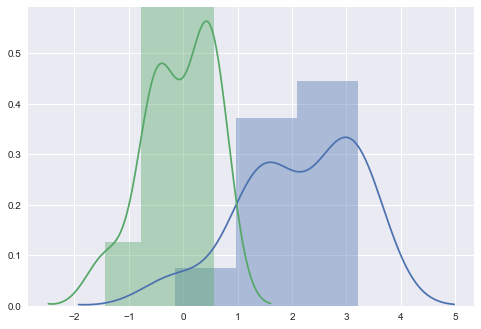

In [60]:
sns.distplot(y)
sns.distplot(y_scaled)

In [61]:
# Standardize numerical features, not using Standard scaler but log2 DESeq2 counts should be relatively normal?
robSc = RobustScaler()

X_scaled = robSc.fit_transform(X)

In [62]:
# Define error measure for official scoring : RMSE
#scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_scaled, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)

# LASSO Regression 

In [63]:
# Lasso
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 5)
lasso.fit(X_scaled, y)
alpha = lasso.alpha_
print("Best alpha :", alpha)

/Users/jzz0026/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best alpha : 0.0001


In [64]:
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 5)
lasso.fit(X_scaled, y)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Lasso RMSE on ALL data:", rmse_cv(lasso).mean())
#print("Lasso RMSE on Training set :", rmse_cv_train(lasso).mean())
#print("Lasso RMSE on Test set :", rmse_cv_test(lasso).mean())
y_train_las = lasso.predict(X_scaled)
#y_test_las = lasso.predict(X_testS)

accuracy = metrics.r2_score(y, y_train_las)
print("R2=", accuracy)

/Users/jzz0026/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best alpha : 0.00014


/Users/jzz0026/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jzz0026/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jzz0026/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jzz0026/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:1094: DataConversionWarning: A 

Lasso RMSE on ALL data: 0.59663224137
R2= 0.999999723947


In [65]:
lasso = Lasso(alpha=alpha,max_iter = 50000)
lasso.fit(X_scaled, y)
y_train_las = lasso.predict(X_scaled)
accuracy = metrics.r2_score(y, y_train_las)
print("R2=", accuracy)

R2= 0.999999723947


In [66]:
sns.set_style("white")
sns.set_style("ticks")
from matplotlib.backends.backend_pdf import PdfPages

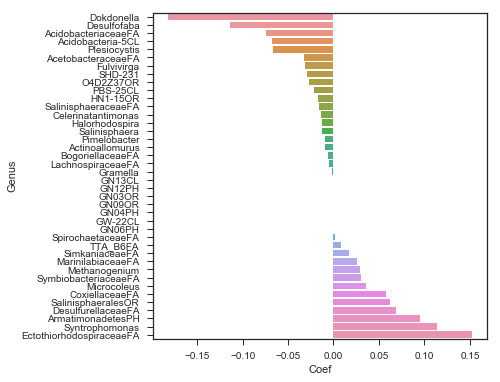

In [80]:
# Extract scaled coefficients
#pp = PdfPages('SP_Lasso_Out.pdf')     
fig = plt.figure(figsize=(6, 6))        # Define plot
coef = pd.Series(lasso.coef_, index = X.columns)
genus_coef = pd.DataFrame(pd.concat([coef.sort_values().head(20),coef.sort_values().tail(20)]))
genus_coef = genus_coef.reset_index()
genus_coef.columns = ["Genus","Coef"]
sns.barplot(data=genus_coef, y='Genus', x='Coef')